# Pipeline walkthrough

## Data import

In [1]:
from preprocessing.import_data import import_dataset

import napari

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"
var1_test_name = "test_data/2023-06-16/RBSPWM_embryo01"
mcp_halo_test_name = "test_data/2023-08-03/embryo6"

test_dataset_name = mcp_halo_test_name

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = import_dataset(test_dataset_name, trim_series=trim_series)

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


In [22]:
nuclear_channel_metadata = export_frame_metadata[1]
nuclear_channel = channels_full_dataset[1]

IndexError: list index out of range

## Starting a Dask Client for parallelization

In [2]:
from dask.distributed import LocalCluster, Client

In [3]:
cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="4GB",
)

In [4]:
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:39599,Total threads: 1
Dashboard: http://127.0.0.1:35125/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:32965,


## Nuclear segmentation and tracking

In [7]:
import pipeline

In [8]:
%%time

nuclear_tracking = pipeline.Nuclear(
    data=nuclear_channel,
    global_metadata=export_global_metadata[1],
    frame_metadata=nuclear_channel_metadata,
    client=client,
    evaluate=True,
)

nuclear_tracking.track_nuclei()

nuclear_tracking.save_results(name_folder=test_dataset_name, save_all=True)

Frame 2: 1 trajectories present.
CPU times: user 1min 1s, sys: 53 s, total: 1min 54s
Wall time: 4min 26s


## Spot segmentation and fitting

It can be shown for an xy-symmetric Gaussian that
$$
\int_{\mathbb{R}^3} A e^{- \frac{x^2 + y^2}{2 \sigma_{xy}^2} - \frac{z^2}{2 \sigma_z^2}} \ dx \ dy \ dz = 2 \sqrt{2} A \pi^{3/2} \sigma_{xy}^2 \sigma_z
$$
where we have used notation consistent with that used in `spot_analysis.fitting`. We can therefore use simple algebraic manipulation of the fit parameters to estimate the spot intensities.

In [9]:
transcription_channel_metadata = export_frame_metadata[0]
transcription_channel = channels_full_dataset[0]

In [10]:
%%time

spot_tracking = pipeline.Spot(
    data=transcription_channel,
    global_metadata=export_global_metadata[0],
    frame_metadata=transcription_channel_metadata,
    labels=nuclear_tracking.reordered_labels_futures,
    client=client,
    keep_bandpass=True,
    keep_spot_mask=True,
)

spot_tracking.extract_spot_traces()

spot_tracking.save_results(name_folder=test_dataset_name, save_all=True)

Frame 167: 23 trajectories present.
CPU times: user 56.1 s, sys: 1min 1s, total: 1min 57s
Wall time: 3min 19s


## Compiling traces

In [11]:
from spot_analysis import compile_data

In [12]:
spot_dataframe = spot_tracking.spot_dataframe
mitosis_dataframe = nuclear_tracking.mitosis_dataframe

compiled_dataframe = compile_data.compile_traces(
    spot_dataframe,
    nuclear_tracking_dataframe=mitosis_dataframe,
    compile_columns_nuclear=["nuclear_cycle", "division_time"],
)

In [13]:
compiled_dataframe

,particle,frame,t_s,intensity_from_fit,nuclear_cycle,division_time
0,1,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...","[1429.706587936108, 1446.419835997688, 1463.32...","[25777.055196510464, 68682.37928585931, 121900...",14,1315.283982
1,2,"[96, 98, 99, 100, 101, 103, 104, 105, 106, 107...","[1666.094064650335, 1699.820489544834, 1716.34...","[10659.59808823916, 19381.33376941381, 23286.7...",14,1188.590651
2,4,"[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[410.7333599773066, 427.55037797700004, 444.48...","[38060.404816230766, 63023.46220728571, 93479....","[13, 14]",374.910144
3,5,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[390.1451299360786, 407.00551743951314, 423.33...","[41555.51807224775, 114600.98691452671, 179446...",13,133.906345
4,6,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...","[553.1203689861926, 570.6858176309763, 586.674...","[25549.833167862846, 75699.26877534739, 92983....","[13, 14]",151.949089
...,...,...,...,...,...,...
196,417,"[98, 99, 100, 101, 103, 104, 105]","[1704.3827603177604, 1719.5145290201112, 1736....","[19921.068849517673, 23153.065779789667, 29124...",14,1202.330819
197,418,"[84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 9...","[1464.4075089842113, 1480.1016528090631, 1495....","[19525.143984280545, 56148.52777982148, 51165....",14,1203.397406
198,419,"[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 9...","[1530.0459133408049, 1547.624060058772, 1564.0...","[28778.581520187956, 30618.538319829222, 76680...",14,1221.623415
199,420,"[86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9...","[1496.7922502266956, 1531.5205885269586, 1548....","[26757.920949519856, 44905.16254096105, 55614....",14,1316.661793


## Visualizing traces

In [14]:
from utils import plottable

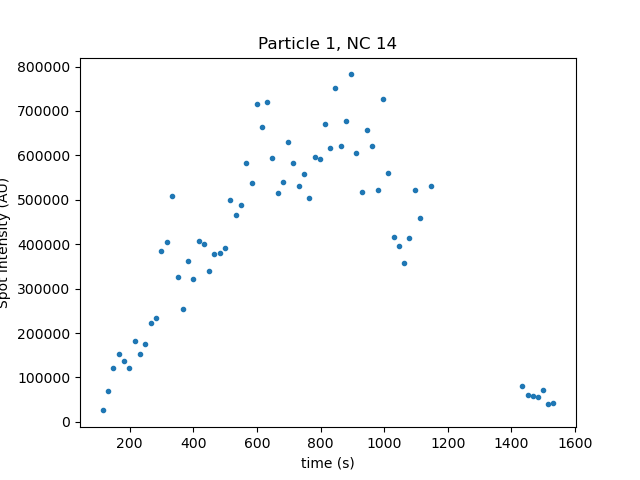

In [15]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

traces = plottable.generate_trace_plot_list(compiled_dataframe)

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")
    ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")
ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")

plt.show()

In [16]:
from tracking import detect_mitosis

In [17]:
viewer = napari.view_image(nuclear_channel, name="Nuclear Channel")
viewer.add_labels(nuclear_tracking.reordered_labels)
_ = detect_mitosis.tracks_to_napari(
    viewer, mitosis_dataframe, name="nuclear_tracks", output=False
)
viewer.add_image(transcription_channel, name="Transcription Channel")
viewer.add_labels(spot_labels)
napari.run()

NameError: name 'spot_labels' is not defined

In [18]:
viewer.add_labels(spot_tracking.reordered_spot_labels)

<Labels layer 'Labels [1]' at 0x7ff5cad919c0>

General procedure for background removal:
1. Blur on xy-lengthscale larger than nuclei, very small z-lengthscale.
2. Automatic threshold and label.
3. Check largest connected component bbox for overlap with top or bottom slice and z-span smaller than predetermined number (either by fraction of z-stack or by absolute length in $\mu m$).
4. If conditions above are met, then that connected component is inverted and passed through as a mask which is applied prior to binarization and watershed segmentation.

## MCP-HaloTag tests

In [6]:
viewer_1 = napari.view_image(channels_full_dataset[0], name="MCP-HaloTag")
napari.run()

In [7]:
halotag_channel = channels_full_dataset[0]

In [8]:
import pipeline

In [9]:
track_spots = pipeline.Spot(
    data=halotag_channel,
    global_metadata=export_global_metadata[0],
    frame_metadata=export_frame_metadata[0],
    labels=None,
    client=client,
)

/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/pipeline.py:608: UserWarning: Resolution is anisotropic in X and Y, segmentation parameters should be handled manually.
  warnings.warn(


In [10]:
track_spots.default_params

{'detect_and_gather_spots_params': {'low_sigma': array([1.924679  , 3.57718098, 3.57718155]),
  'high_sigma': array([3.0794864 , 5.72348957, 5.72349048]),
  'threshold': 'triangle',
  'min_size': 4,
  'connectivity': 1,
  'span': array([10.32566259, 31.98521572, 31.98522081]),
  'pos_columns': ['z', 'y', 'x'],
  'return_bandpass': True,
  'return_spot_mask': True,
  'drop_reverse_time': True},
 'add_fits_spots_dataframe_parallel_params': {'sigma_x_y_guess': 3.1985215722510483,
  'sigma_z_guess': 1.7209437655610338,
  'amplitude_guess': None,
  'offset_guess': None,
  'method': 'trf',
  'inplace': True},
 'track_and_filter_spots_params': {'sigma_x_y_bounds': array([0.79201487, 7.92014866]),
  'sigma_z_bounds': array([0.64035117, 4.0021948 ]),
  'expand_distance': 2,
  'search_range': 63.97043144502098,
  'memory': 2,
  'pos_columns': ['y', 'x'],
  't_column': 'frame_reverse',
  'velocity_predict': True,
  'velocity_averaging': None,
  'min_track_length': 5,
  'choose_by': 'amplitude',
 

In [11]:
track_spots.default_params["track_and_filter_spots_params"]["adaptive_stop"] = 1
track_spots.default_params["track_and_filter_spots_params"]["adaptive_step"] = 0.99

In [12]:
track_spots.extract_spot_traces()

Frame 61: 25 trajectories present.


In [13]:
viewer_1.add_labels(track_spots.reordered_spot_labels)

<Labels layer 'Labels' at 0x7f5ec1358850>

In [14]:
spot_df = track_spots.spot_dataframe

In [15]:
detected_spots = spot_df[spot_df["particle"] != 0]

In [16]:
detected_spots

,label,z,y,x,frame,t_s,t_frame,raw_spot,coordinates_start,sigma_x_y,sigma_z,amplitude,offset,cost,norm_cost,intensity_from_fit,particle
3,4,6.887794,83.015133,281.601995,1,2.035000,0,"[[[3, 2, 5, 8, 7, 3, 3, 5, 4, 7, 7, 8, 6, 5, 7...","[0, 1, 67, 266]",3.393916,3.357325,36.350582,5.727393,59962.561700,0.000901,22139.951578,69
9,10,6.949436,98.819412,2.145610,1,2.035000,0,"[[[2, 5, 0, 4, 11, 6, 4, 2, 1, 2, 3, 4, 2, 4, ...","[0, 1, 83, -14]",2.089281,2.153562,20.844049,4.669270,31000.918771,0.001130,3086.049318,125
11,12,7.959006,19.412881,428.382256,1,2.375000,0,"[[[8, 8, 5, 8, 9, 5, 2, 7, 2, 3, 5, 3, 4, 3, 3...","[0, 2, 4, 412]",3.605941,2.817214,12.679278,5.416717,41125.663876,0.002140,7315.118231,68
14,15,7.995970,180.043282,17.986185,1,2.375000,0,"[[[6, 4, 4, 7, 6, 4, 3, 8, 1, 5, 1, 3, 9, 1, 2...","[0, 2, 164, 2]",3.110780,2.770048,19.151048,4.951133,35109.628855,0.001309,8085.156325,72
15,16,8.348491,2.710734,323.077846,1,2.715000,0,"[[[6, 4, 6, 3, 5, 2, 5, 3, 7, 7, 3, 8, 6, 8, 2...","[0, 3, -13, 307]",3.013660,2.078145,17.529508,6.325354,49593.345888,0.001700,5210.794469,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8081,22,11.444751,14.494628,434.223176,61,432.664999,60,"[[[6, 7, 3, 4, 9, 1, 2, 6, 2, 2, 5, 4, 6, 6, 7...","[60, 4, -1, 418]",3.605978,2.603910,3.855553,3.608402,21933.871195,0.005139,2056.025452,10
8083,24,12.466948,38.018072,154.055478,61,433.003000,60,"[[[5, 5, 4, 9, 5, 2, 3, 5, 2, 3, 5, 4, 5, 0, 5...","[60, 5, 22, 138]",3.291425,3.072852,5.457981,3.953402,23539.837964,0.003761,2861.616363,11
8084,25,12.110201,110.520046,99.578862,61,433.003000,60,"[[[4, 11, 1, 5, 5, 6, 2, 6, 3, 6, 5, 6, 5, 3, ...","[60, 5, 95, 84]",2.596190,2.650430,6.789636,4.679112,28603.956328,0.003332,1910.318472,12
8087,28,9.483587,189.284013,82.203468,61,432.323000,60,"[[[3, 4, 4, 6, 7, 4, 5, 5, 4, 4, 7, 5, 4, 9, 7...","[60, 3, 173, 65]",1.809520,2.549193,6.408982,5.188562,30288.847080,0.003633,842.535517,13


In [17]:
import matplotlib.pyplot as plt

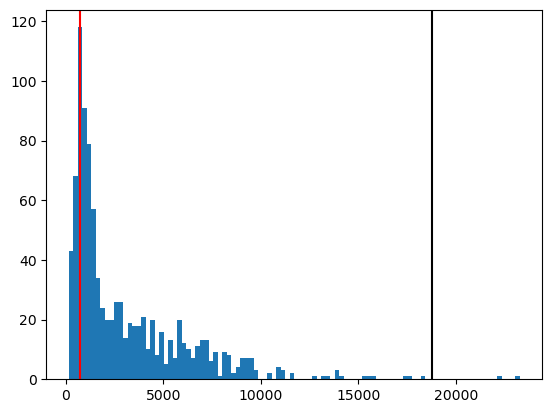

In [18]:
plt.hist(detected_spots["intensity_from_fit"], bins=100)
plt.axvline(x=750, color="red")
plt.axvline(x=750 * 25, color="black")

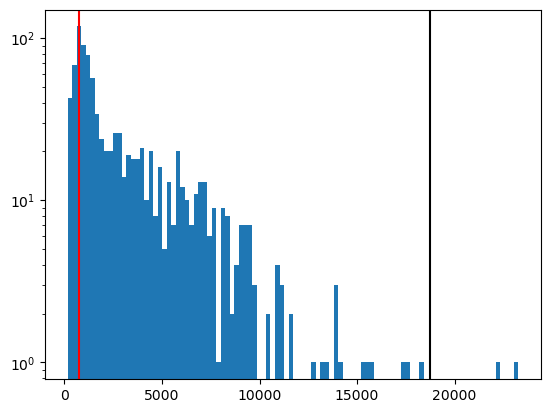

In [19]:
plt.hist(detected_spots["intensity_from_fit"], bins=100, log=True)
plt.axvline(x=750, color="red")
plt.axvline(x=750 * 25, color="black")

To do:
- Add import spot from previous run
- Add import and export results from nuclear analysis
- Write walkthrough
- Distribute as package
- Write class wrapper around data import functions.